In [1]:
import os
import glob
import torch
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    Spacingd, ScaleIntensityRanged, CropForegroundd, Invertd,
    AsDiscreted, SaveImaged, Resized, ThresholdIntensityd, NormalizeIntensityd
)
from monai.data import Dataset, DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet, SwinUNETR
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import monai.transforms as t
from monai.transforms import LoadImage

2024-09-07 09:18:51.623473: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 09:18:51.680027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 09:18:52.504968: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_dir = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data"  # Update this path to your test data directory
model_path = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/experiments/AMOS_pesos/best_model.pth"  # Update this path to your saved model
output_dir = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/test_results/results_pesos"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#test_images = sorted(glob.glob(os.path.join(data_dir, "Ts_images", "*.nii.gz")))
#test_data = [{"image": image} for image in test_images]
image = '/data/PANORAMA/cvillaseca/panorama_batch1/batch_1/100014_00001_0000.nii.gz'
data_dict = {'image': image}

In [4]:
import nibabel as nib
# Cargar los archivos NIfTI
img_nifti = nib.load(image)

# Obtener los datos en formato NumPy
img_data = img_nifti.get_fdata()

In [5]:
# Define test transforms
wl, ww = -40, 400  # https://www.stepwards.com/?page_id=21646#ABDOMINAL_WINDOW
clamp1 = ThresholdIntensityd(keys=('image',), above=False, threshold=wl + (ww / 2), cval=wl + (ww / 2))
clamp2 = ThresholdIntensityd(keys=('image',), above=True, threshold=wl - (ww / 2), cval=wl - (ww / 2))
norm = NormalizeIntensityd(keys=('image',), nonzero=True)
intensities = Compose([clamp1, clamp2, norm])

space = t.Spacingd(keys=('image',), pixdim=(1.5,1.5,1.5), mode=('bilinear'))


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        intensities,
        space,
    ]
)

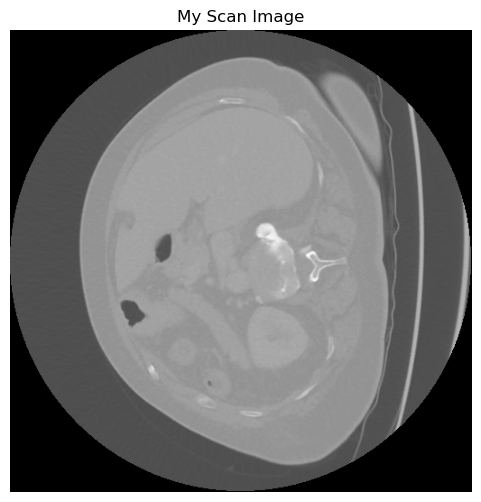

In [6]:
slice_index = img_data.shape[2] // 2  # Encuentra el corte central
slice_data = img_data[:, :, slice_index]

plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap='gray')
plt.title("My Scan Image")
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()

torch.Size([512, 512, 258])


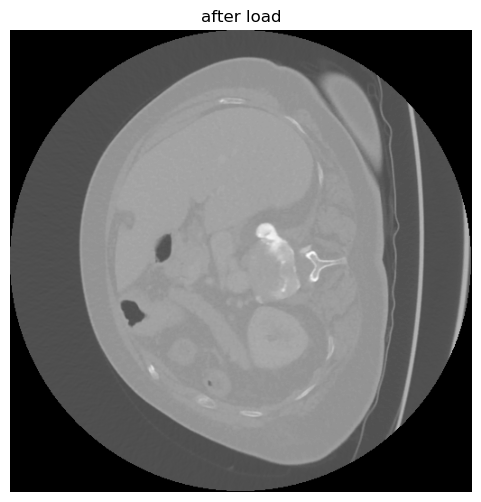

In [7]:
load= t.LoadImaged(keys="image", ensure_channel_first=True, image_only=True)
loaded = load(data_dict)
scan = loaded['image'][0]
print(scan.shape)

slice_index = scan.shape[2] // 2  # Encuentra el corte central
slice_data = scan[:, :, slice_index]
plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap='gray')
plt.title("after load")
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()

torch.Size([512, 512, 258])


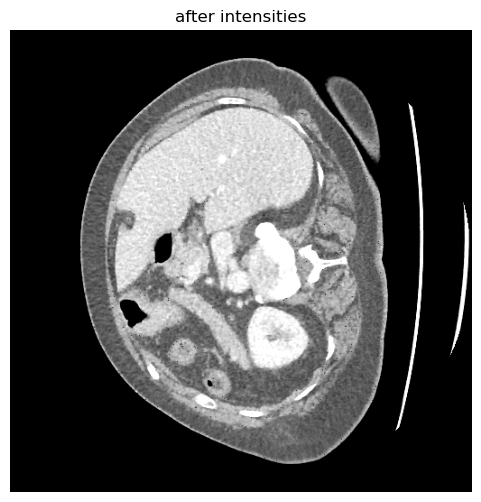

In [8]:
intensified= intensities(loaded)
scan = intensified['image'][0]
print(scan.shape)

slice_index = scan.shape[2] // 2  # Encuentra el corte central
slice_data = scan[:, :, slice_index]
plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap='gray')
plt.title("after intensities")
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()

torch.Size([267, 267, 412])


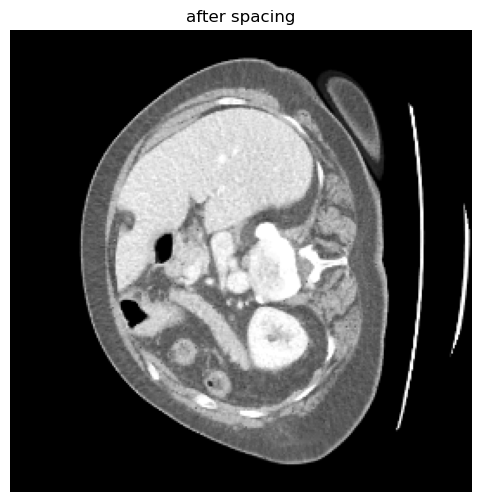

In [9]:
space = t.Spacingd(keys=('image'), pixdim=(1.5,1.5,1.5), mode=('bilinear'))
spaced = space(intensified)
scan = spaced['image'][0]
print(scan.shape)

slice_index = scan.shape[2] // 2  # Encuentra el corte central
slice_data = scan[:, :, slice_index]
plt.figure(figsize=(6, 6))
plt.imshow(slice_data, cmap='gray')
plt.title("after spacing")
plt.axis('off')  # Elimina los ejes para una visualización más limpia
plt.show()

In [ ]:
# Create dataset and dataloader
test_org_ds = Dataset(data=spaced)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

In [10]:
# Load model
model = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=5, feature_size=12, use_checkpoint=False)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 12, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=12, out_features=36, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=12, out_features=12, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=12, out_features=48, bias=True)
              (linear2): Linear(in_features=

In [11]:
def from_engine(keys):
    def _extract_data(data):
        if isinstance(keys, list):
            return {key: data[key] for key in keys}
        else:
            return data[keys]
    return _extract_data

In [12]:
spaced['image'] = spaced['image'].unsqueeze(0)  # Add batch dimension

In [13]:
model.to('cpu')
test_input = spaced['image'].to('cpu')

In [14]:
import nibabel as nib
import numpy as np

# Asegúrate de que el tensor está en la CPU y conviértelo a un array de NumPy
test_input_np = test_input.cpu().numpy()

# Crear una matriz de identidad para el affine (esto puede variar dependiendo de la geometría de tu imagen)
affine = np.eye(4)

# Crear la imagen NIfTI
nifti_image = nib.Nifti1Image(test_input_np, affine)

# Guardar la imagen en un archivo NIfTI
output_path = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data/test_inputs/test_input_result.nii.gz"
nib.save(nifti_image, output_path)

print(f"Imagen guardada en: {output_path}")

Imagen guardada en: /data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data/test_inputs/test_input_result.nii.gz


In [15]:
# Now you can check the shape to make sure it is correct
print(f"Shape of input tensor: {spaced['image'].shape}")

print(test_input.shape)
roi_size = (96, 96, 96)
spaced['pred']= sliding_window_inference(test_input, roi_size, sw_batch_size=1, predictor=model, overlap=0.1)
        

Shape of input tensor: torch.Size([1, 1, 267, 267, 412])
torch.Size([1, 1, 267, 267, 412])


In [16]:
import numpy as np
pred_np = spaced['pred'].cpu().detach().numpy()  # Asegúrate de mover la predicción a la CPU si está en la GPU
pred_nii = nib.Nifti1Image(pred_np, affine=np.eye(4))  # Asegúrate de tener la matriz affine correcta
output_path = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/test_results/results_pesos"
nib.save(pred_nii, output_path)


OSError: [Errno 28] No space left on device

In [17]:
extract_pred = from_engine("pred")
test_output = extract_pred(spaced)

Tamaño de la imagen de etiqueta (ground truth): (238, 238, 143)
Tamaño de la imagen segmentada: (5, 238, 238, 143)


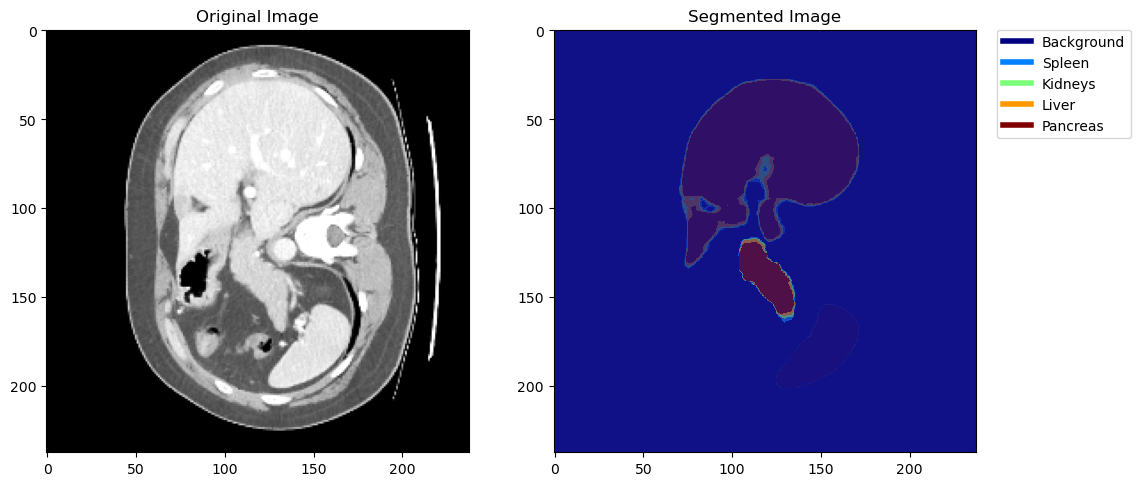

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Cargar las imágenes
original_image = nib.load("/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data/test_inputs/test_input_result.nii.gz").get_fdata()
segmented_image = nib.load("/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/test_results/results_pesos/results_pesos.nii").get_fdata()

# Eliminar dimensiones extra de la imagen segmentada si es necesario
original_image= np.squeeze(original_image)
segmented_image = np.squeeze(segmented_image)  # Elimina dimensiones de tamaño 1

# Obtener las formas (tamaños) de las imágenes
original_image_shape = original_image.shape
segmented_image_shape = segmented_image.shape

print(f"Tamaño de la imagen de etiqueta (ground truth): {original_image_shape}")
print(f"Tamaño de la imagen segmentada: {segmented_image_shape}")

# Colores y etiquetas para las clases
class_labels = ['Background', 'Spleen', 'Kidneys', 'Liver', 'Pancreas']
colormap = plt.cm.get_cmap('jet', len(class_labels))
norm = mcolors.Normalize(vmin=0, vmax=len(class_labels) - 1)

# Selecciona la rebanada central
slice_index = original_image.shape[2] // 2  # Rebanada central de la imagen original
segmented_slice_index = segmented_image.shape[3] // 2  # Rebanada central de la imagen segmentada

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image[:, :, 83], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Segmented Image")

# Superponer todos los canales de segmentación
for i in range(1, segmented_image.shape[0]):  # Comenzar desde 1 para saltar el fondo
    plt.imshow(segmented_image[i, :, :, 83], cmap=colormap, norm=norm, alpha=0.5)  # Superponer con transparencia

handles = [plt.Line2D([0], [0], color=colormap(norm(i)), lw=4) for i in range(len(class_labels))]
plt.legend(handles=handles, labels=class_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


Tamaño de la imagen de etiqueta (ground truth): (238, 238, 143)
Tamaño de la imagen segmentada: (5, 238, 238, 143)


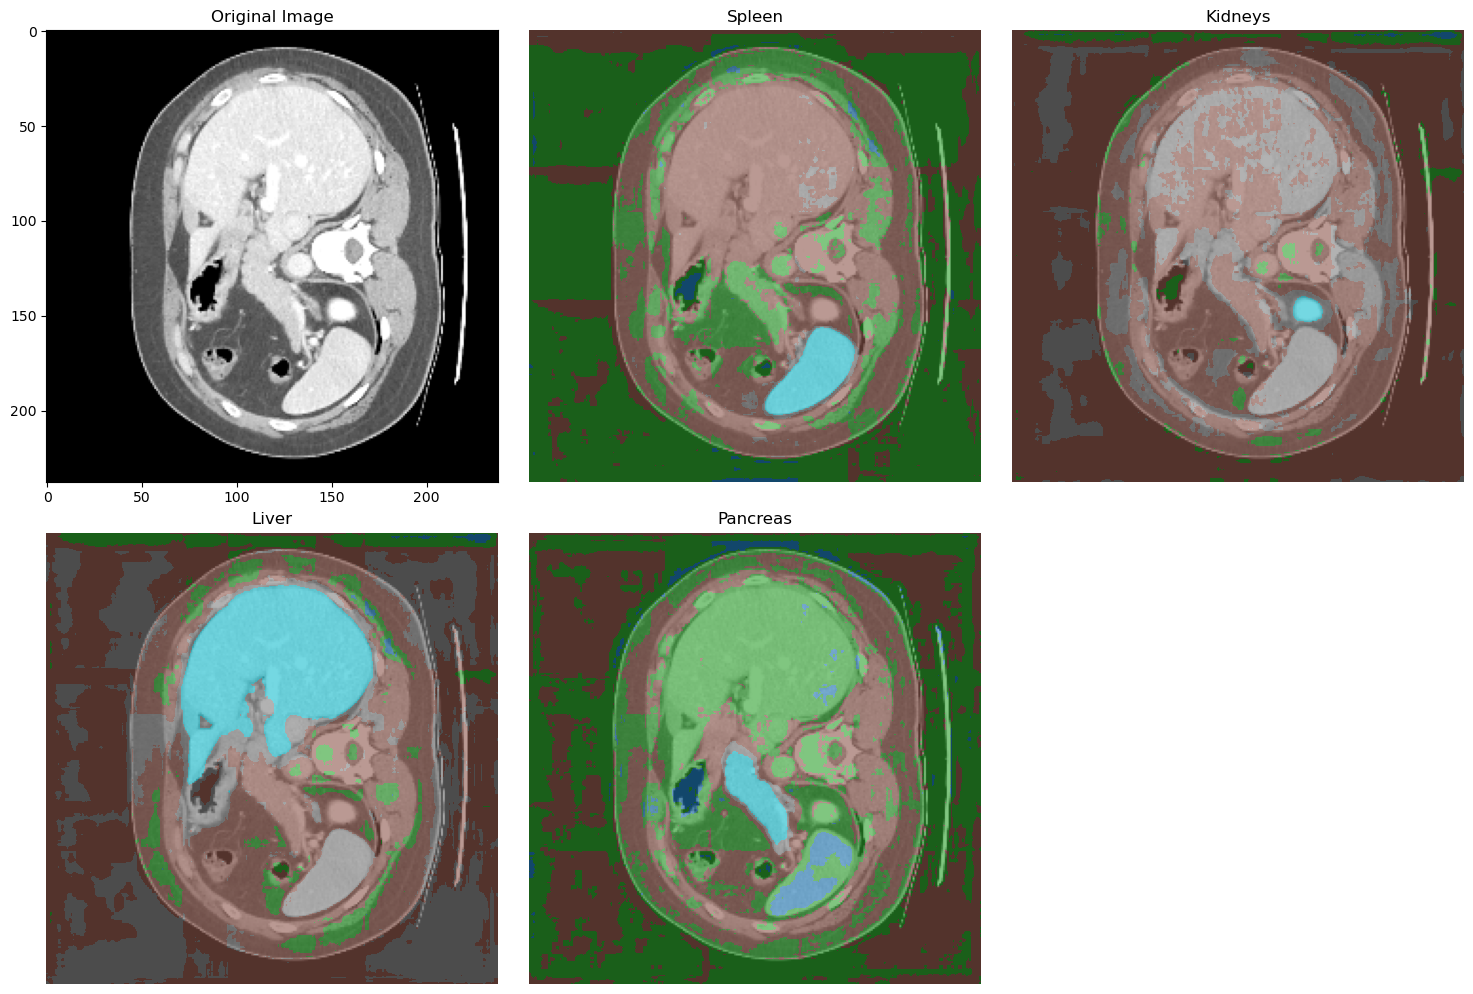

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Cargar las imágenes
original_image = nib.load("/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data/test_inputs/test_input_result.nii.gz").get_fdata()
segmented_image = nib.load("/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/test_results/results_pesos/results_pesos.nii").get_fdata()

# Eliminar dimensiones extra de la imagen segmentada si es necesario
original_image = np.squeeze(original_image)
segmented_image = np.squeeze(segmented_image)  # Elimina dimensiones de tamaño 1

# Obtener las formas (tamaños) de las imágenes
original_image_shape = original_image.shape
segmented_image_shape = segmented_image.shape

print(f"Tamaño de la imagen de etiqueta (ground truth): {original_image_shape}")
print(f"Tamaño de la imagen segmentada: {segmented_image_shape}")

# Colores y etiquetas para las clases
class_labels = ['Background', 'Spleen', 'Kidneys', 'Liver', 'Pancreas']
colormap = plt.cm.get_cmap('tab10', len(class_labels))

# Selecciona la rebanada central
slice_index = original_image.shape[2] // 2  # Rebanada central de la imagen original
segmented_slice_index = segmented_image.shape[3] // 2  # Rebanada central de la imagen segmentada

# Crear subgráficos para cada clase
plt.figure(figsize=(15, 10))

# Mostrar la imagen original en el primer subgráfico
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(original_image[:, :, 80], cmap="gray")

# Mostrar cada clase segmentada en subgráficos individuales
for i in range(1, segmented_image.shape[0]):  # Comenzar desde 1 para saltar el fondo
    plt.subplot(2, 3, i + 1)
    plt.title(class_labels[i])
    plt.imshow(original_image[:, :, 80], cmap="gray")
    plt.imshow(segmented_image[i, :, :, 80], cmap=colormap, alpha=0.6)
    plt.axis('off')

plt.tight_layout()
plt.show()


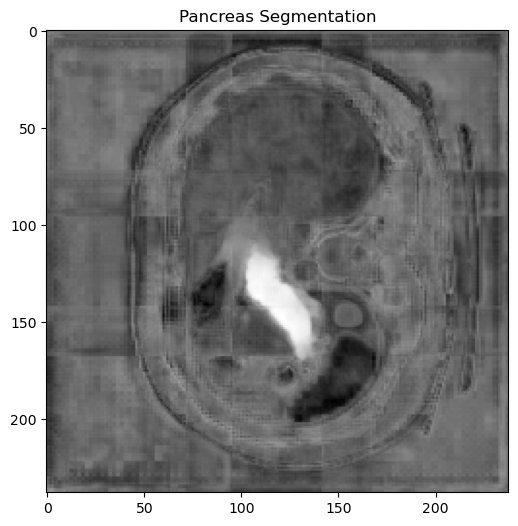

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Cargar la imagen segmentada
segmented_img = nib.load("/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/test_results/results_pesos/results_pesos.nii")
segmented_data = segmented_img.get_fdata()

# Eliminar dimensiones extra de la imagen segmentada si es necesario
segmented_data = np.squeeze(segmented_data)  # Elimina dimensiones de tamaño 1

# Especificar la clase que deseas visualizar (e.g., clase 4)
class_to_visualize = 4

# Crear una máscara donde solo esté presente la clase especificada
class_mask = segmented_data[class_to_visualize]  # Selecciona el canal correspondiente a la clase

# Elegir una rebanada para visualizar
slice_index = segmented_data.shape[2] // 2  # Rebanada central

# Plot de la segmentación para la clase específica
plt.figure(figsize=(6, 6))
plt.imshow(class_mask[:, :, 80], cmap="gray")
plt.title(f"Pancreas Segmentation")
plt.show()


(512, 512, 85)
[0. 1. 2. 3. 4. 5. 6.]


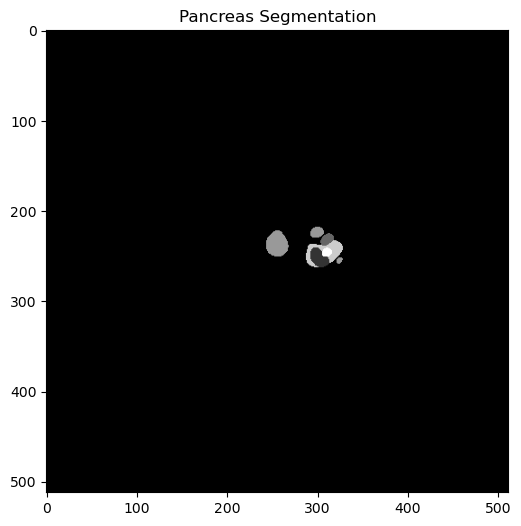

Forma original de la etiqueta: (512, 512, 85)
El tensor no está en formato one-hot, su forma es: (512, 512, 85)


In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Cargar la imagen segmentada
label = nib.load("/data/PANORAMA/cvillaseca/panorama_labels/manual_labels/100034_00001.nii.gz")
label_data = label.get_fdata()

print(label_data.shape)
print(np.unique(label_data))
slice_index = label_data.shape[2] // 2  # Rebanada central

# Plot de la segmentación para la clase específica
plt.figure(figsize=(6, 6))
plt.imshow(label_data[:, :, slice_index], cmap="gray")
plt.title(f"Pancreas Segmentation")
plt.show()

def check_one_hot(tensor):
    """
    Comprobar si un tensor está en formato one-hot.
    """
    if len(tensor.shape) == 5:  # (B, C, H, W, D) para un tensor 3D
        print(f"El tensor parece estar en formato one-hot con {tensor.shape[1]} clases.")
        # Verifica si solo hay un 1 en la dimensión de la clase para cada voxel
        if torch.all((tensor.sum(dim=1) == 1)):
            print("El tensor está correctamente en formato one-hot.")
        else:
            print("El tensor no está correctamente en formato one-hot.")
    else:
        print(f"El tensor no está en formato one-hot, su forma es: {tensor.shape}")

# Usa la función después de cargar las etiquetas
print(f"Forma original de la etiqueta: {label.shape}")
check_one_hot(label)

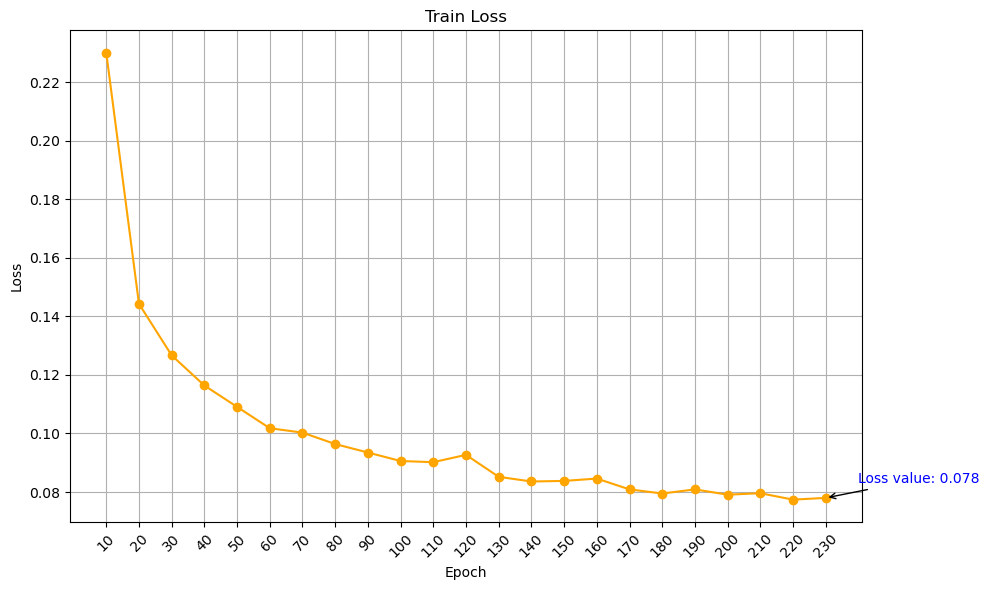

In [ ]:
import matplotlib.pyplot as plt

# Datos de pérdida proporcionados
loss_values = [
    0.2301, 0.1443, 0.1267, 0.1164, 0.1091, 0.1018, 0.1003, 0.0964, 0.0935, 
    0.0906, 0.0902, 0.0927, 0.0852, 0.0836, 0.0838, 0.0846, 0.0809, 0.0795, 
    0.0809, 0.0791, 0.0796, 0.0774, 0.0780
]

epochs = list(range(10, 240, 10))

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='orange')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Mostrar el último valor de pérdida
plt.annotate(f'Loss value: {loss_values[-1]}', 
             xy=(epochs[-1], loss_values[-1]), 
             xytext=(epochs[-1]+10, loss_values[-1]+0.005),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

# Asegurar que la última epoch es claramente visible
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


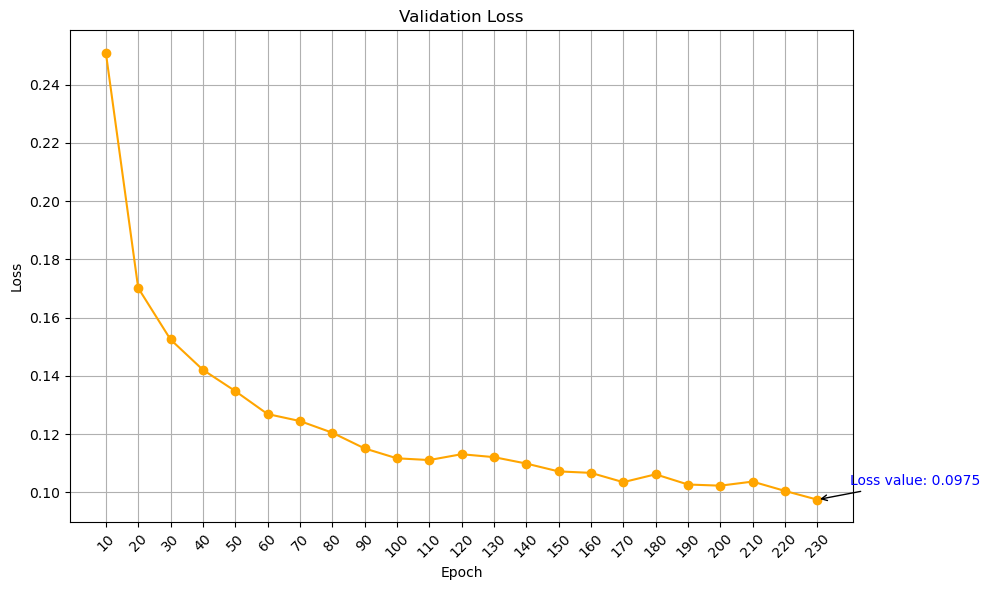

In [ ]:
import matplotlib.pyplot as plt

# Datos de pérdida proporcionados
loss_values = [
    0.2510, 0.1702, 0.1525, 0.1421, 0.1348, 0.1269, 0.1245, 0.1205, 0.1151, 
    0.1117, 0.1111, 0.1131, 0.1121, 0.1099, 0.1072, 0.1067, 0.1035, 0.1062, 
    0.1027, 0.1023, 0.1037, 0.1005, 0.0975
]

epochs = list(range(10, 240, 10))

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Mostrar el último valor de pérdida
plt.annotate(f'Loss value: {loss_values[-1]}', 
             xy=(epochs[-1], loss_values[-1]), 
             xytext=(epochs[-1]+10, loss_values[-1]+0.005),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

# Asegurar que la última epoch es claramente visible
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


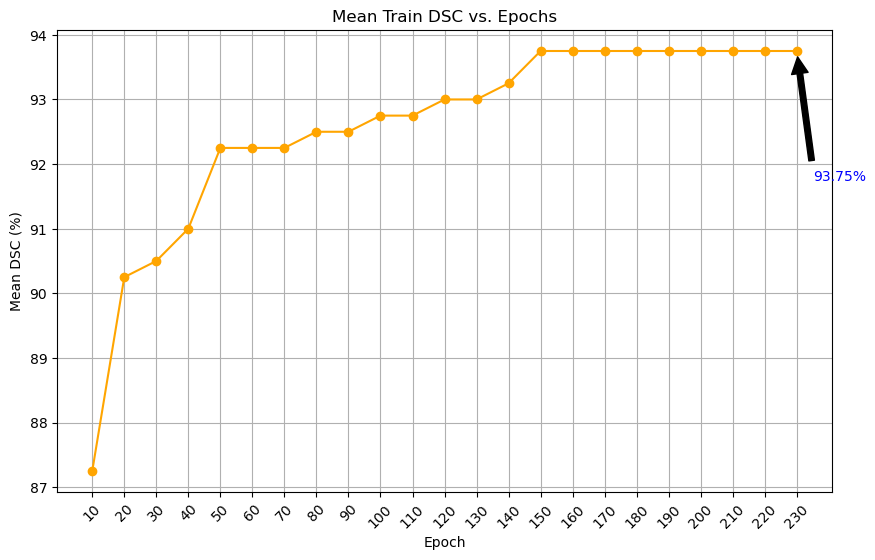

In [ ]:
import matplotlib.pyplot as plt

# Datos extraídos manualmente del texto proporcionado
epochs = list(range(10, 240, 10))
dsc_values = [
    [0.90, 0.94, 0.95, 0.70],
    [0.94, 0.95, 0.96, 0.76],
    [0.94, 0.95, 0.96, 0.77],
    [0.95, 0.95, 0.96, 0.78],
    [0.96, 0.96, 0.97, 0.80],
    [0.96, 0.96, 0.97, 0.80],
    [0.96, 0.96, 0.97, 0.80],
    [0.96, 0.96, 0.97, 0.81],
    [0.96, 0.96, 0.97, 0.81],
    [0.96, 0.96, 0.97, 0.82],
    [0.96, 0.96, 0.97, 0.82],
    [0.96, 0.96, 0.97, 0.83],
    [0.96, 0.96, 0.97, 0.83],
    [0.96, 0.96, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84],
    [0.97, 0.97, 0.97, 0.84]
]

# Calcular la media de los valores DSC para cada epoch y convertir a porcentaje
mean_dsc = [sum(dsc) / len(dsc) * 100 for dsc in dsc_values]

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_dsc, marker='o', color='orange', linestyle='-', label='Mean Train DSC')
plt.title("Mean Train DSC vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean DSC (%)")
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Anotación del último valor
plt.annotate(f'{mean_dsc[-1]:.2f}%', 
             xy=(epochs[-1], mean_dsc[-1]), 
             xytext=(epochs[-1]+5, mean_dsc[-1]-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

plt.show()


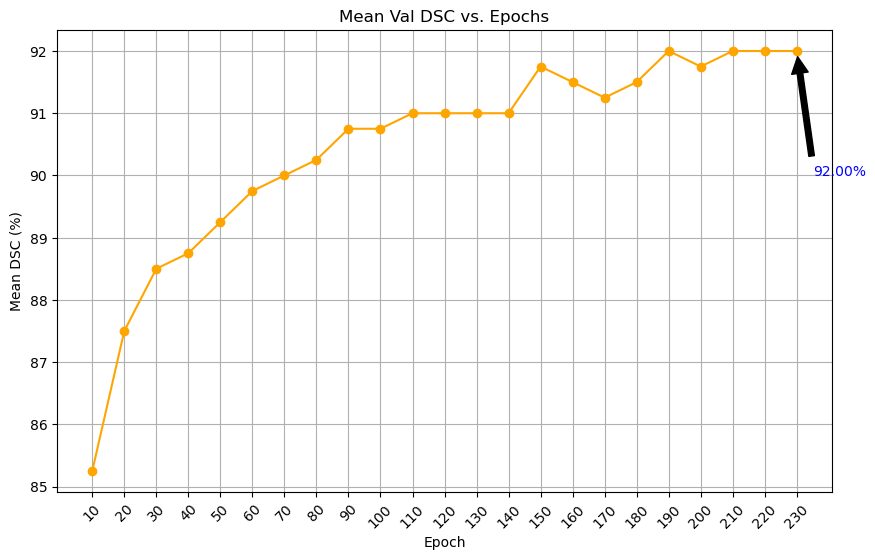

In [ ]:
import matplotlib.pyplot as plt

# Datos extraídos manualmente del texto proporcionado
epochs = list(range(10, 240, 10))
val_dsc_values = [
    [0.91, 0.89, 0.94, 0.67],
    [0.92, 0.91, 0.95, 0.72],
    [0.93, 0.91, 0.96, 0.74],
    [0.93, 0.91, 0.96, 0.75],
    [0.93, 0.92, 0.96, 0.76],
    [0.94, 0.92, 0.96, 0.77],
    [0.94, 0.92, 0.96, 0.78],
    [0.95, 0.92, 0.96, 0.78],
    [0.95, 0.93, 0.96, 0.79],
    [0.95, 0.93, 0.96, 0.79],
    [0.95, 0.93, 0.97, 0.79],
    [0.95, 0.93, 0.97, 0.79],
    [0.95, 0.93, 0.96, 0.80],
    [0.95, 0.93, 0.96, 0.80],
    [0.96, 0.94, 0.97, 0.80],
    [0.95, 0.94, 0.97, 0.80],
    [0.95, 0.93, 0.97, 0.80],
    [0.96, 0.93, 0.97, 0.80],
    [0.96, 0.94, 0.97, 0.81],
    [0.96, 0.94, 0.97, 0.80],
    [0.96, 0.94, 0.97, 0.81],
    [0.96, 0.94, 0.97, 0.81],
    [0.96, 0.94, 0.97, 0.81]
]

# Calcular la media de los valores DSC para cada epoch y convertir a porcentaje
mean_val_dsc = [sum(dsc) / len(dsc) * 100 for dsc in val_dsc_values]

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_val_dsc, marker='o', color='orange', linestyle='-', label='Mean Val DSC')
plt.title("Mean Val DSC vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean DSC (%)")
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Anotación del último valor
plt.annotate(f'{mean_val_dsc[-1]:.2f}%', 
             xy=(epochs[-1], mean_val_dsc[-1]), 
             xytext=(epochs[-1]+5, mean_val_dsc[-1]-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

plt.show()


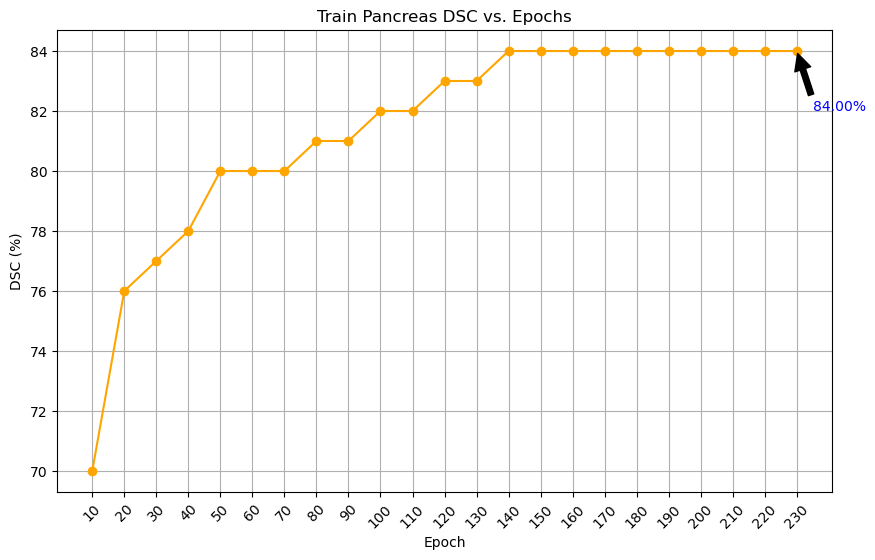

In [ ]:
import matplotlib.pyplot as plt

# Datos extraídos manualmente del texto proporcionado
epochs = list(range(10, 240, 10))
train_pancreas_dsc = [
    0.70, 0.76, 0.77, 0.78, 0.80, 0.80, 0.80, 0.81, 0.81, 0.82, 
    0.82, 0.83, 0.83, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 
    0.84, 0.84, 0.84
]

# Convertir a porcentaje
train_pancreas_dsc_percent = [dsc * 100 for dsc in train_pancreas_dsc]

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_pancreas_dsc_percent, marker='o', color='orange', linestyle='-', label='Train Pancreas DSC')
plt.title("Train Pancreas DSC vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("DSC (%)")
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Anotación del último valor
plt.annotate(f'{train_pancreas_dsc_percent[-1]:.2f}%', 
             xy=(epochs[-1], train_pancreas_dsc_percent[-1]), 
             xytext=(epochs[-1]+5, train_pancreas_dsc_percent[-1]-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

plt.show()


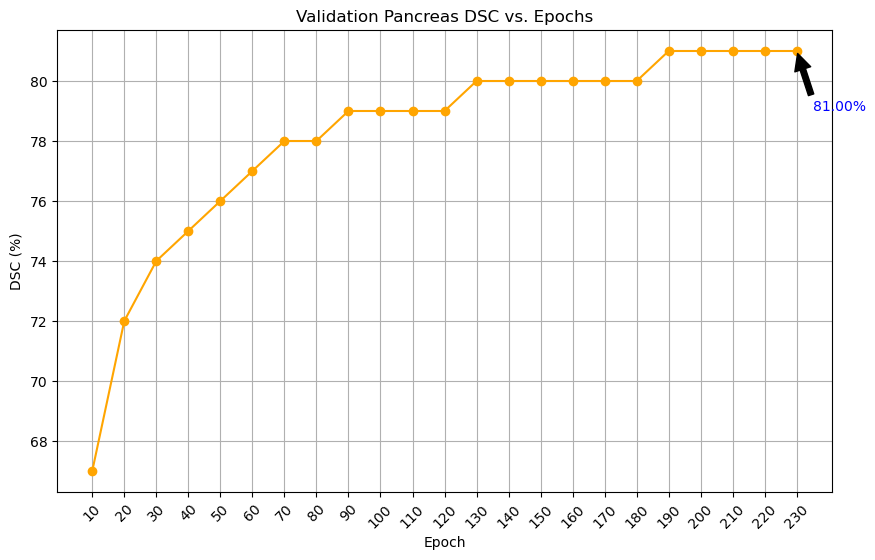

In [ ]:
import matplotlib.pyplot as plt

# Datos extraídos manualmente del texto proporcionado
epochs = list(range(10, 240, 10))
val_pancreas_dsc = [
    0.67, 0.72, 0.74, 0.75, 0.76, 0.77, 0.78, 0.78, 0.79, 0.79, 
    0.79, 0.79, 0.80, 0.80, 0.80, 0.80, 0.80, 0.80, 0.81, 0.81, 
    0.81, 0.81, 0.81
]

# Convertir a porcentaje
val_pancreas_dsc_percent = [dsc * 100 for dsc in val_pancreas_dsc]

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_pancreas_dsc_percent, marker='o', color='orange', linestyle='-', label='Validation Pancreas DSC')
plt.title("Validation Pancreas DSC vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("DSC (%)")
plt.xticks(epochs, rotation=45)
plt.grid(True)

# Anotación del último valor
plt.annotate(f'{val_pancreas_dsc_percent[-1]:.2f}%', 
             xy=(epochs[-1], val_pancreas_dsc_percent[-1]), 
             xytext=(epochs[-1]+5, val_pancreas_dsc_percent[-1]-2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

plt.show()


In [1]:
all_dsc= [
    0.7962263481761274,
    0.6811045078244622,
    0.719813573462988,
    0.7441270074872606,
    0.5504997060552617,
    0.6251446759259259,
    0.3719249154716101,
    0.8198424068767909,
    0.4710595474649061,
    0.4553587565515995,
    0.5264045374415575,
    0.8367936450622856,
    0.7090609102158669,
    0.7876876015677278,
    0.8726408868945493,
    0.8283430084529992,
    0.4487208399107971,
    0.6207162534435262,
    0.5757777566359052,
    0.8246935529147562,
    0.8069746872762499,
    0.7840839527765632,
    0.8029901342952758,
    0.7353882277111484,
    0.8068734738174912,
    0.839362022269034,
    0.8078265070588867,
    0.7869591872482046,
    0.4430446194225722,
    0.7208874687245651,
    0.8129930074747683,
    0.6288169891544075,
    0.6432658556522576,
    0.3176148463644661,
    0.8018253538556733,
    0.5718295295073491,
    0.47555603893632065,
    0.4714208923132055,
    0.4826038159371493,
    0.658361153262519,
    0.7973403296549237,
    0.5305478519354999,
    0.8345570143495463,
    0.7621100164203612,
    0.4370331245755678,
    0.5030372681004761,
    0.7244830438378825,
    0.748056016558823,
    0.6829944913407047,
    0.43801295896328296,
    0.8239329514933825,
    0.7992279213998671,
    0.6811329716757081,
    0.5393837910247823,
    0.7669494512725308,
    0.7499554022715109,
    0.7513106566949089,
    0.44641042710486667,
    0.7470183014600041,
    0.3420224842036161,
    0.6822682786413357,
    0.7738959596822413,
    0.4057214336215805,
    0.3269354394342915,
    0.580520452278018,
    0.689083119108826,
    0.5279625966552778,
    0.6621954873354998,
    0.6673318614130435,
    0.7243885771086583,
    0.6670739596061238,
    0.6446762203567088,
    0.4306593774405891,
    0.7916725129788129,
    0.378469153261446,
    0.44052109663620453,
    0.5394101876675603,
    0.8398804216709498,
    0.8331380550280797,
    0.43040467137425314,
    0.8542421078355141,
    0.7283518843692406,
    0.29385678883526806,
    0.8212598696686549,
    0.529847673939893,
    0.7444489301574485,
    0.6610526315789473,
    0.7386038464097957,
    0.5952611578868937,
    0.6375677028810705,
    0.7914101453027046,
    0.8210038212184965,
    0.5123936772168072,
    0.5731824285440246,
    0.6494263230612123,
    0.5362045630317092,
    0.70348059955018,
    0.6085804872175623,
    0.5161114416022209,
    0.40933232169954475,
    0.3787284238908014,
    0.5857795923061442,
    0.8292317924842035,
    0.4465765902535297,
    0.2560689389427961,
    0.8244916003536693,
    0.7601811768478435,
    0.7620362036203621,
    0.7565632458233891,
    0.2755598831548199,
    0.7669585893936604,
    0.8139739235756525,
    0.858016652855057,
    0.44183390438897047,
    0.7528313509927499,
    0.3259033642530804,
    0.7731083044595954,
    0.696893137589621,
    0.6409479686386315,
    0.7930040053404539,
    0.46416950435111615,
    0.7818991639589646,
    0.6120065840554054,
    0.6359774243201642,
    0.7633556084116736,
    0.7972984467770198,
    0.5451764509580356,
    0.6708263463713294,
    0.6751609128145114,
    0.5704115050548199,
    0.7284271725826194,
    0.6512457730846628,
    0.6885413414322613,
    0.7599915287568451,
    0.7839632746748278,
    0.25673641427066085,
    0.7818334382211034,
    0.6966393074441586,
    0.3335827135501474,
    0.7426045904274019,
    0.5253692370461036,
    0.6407106754480012,
    0.3746246531605154,
    0.7285472564660382,
    0.7110262784090909,
    0.5280172413793104,
    0.8866078448501791,
    0.5162523900573613,
    0.2878276250200997,
    0.8594704684317719,
    0.8232141860335299,
    0.5442038561892176,
    0.7346825396825397,
    0.2542269301283357,
    0.8211443802408607,
    0.7142352656915042,
    0.788200115586602,
    0.5030056773906267,
    0.7619375202330851,
    0.6408878504672897,
    0.807715167666852,
    0.6676970174317517,
    0.8117187224902286,
    0.6121521649329679,
    0.8507531438573863,
    0.6995012778205096,
    0.3590913156247205,
    0.3868834577495995,
    0.4948553382233089,
    0.8814658951429073,
    0.557585937273754,
    0.5523962026764269,
    0.5907255003188678,
    0.28389913338111683,
    0.5578519356158121,
    0.7506482379202273,
    0.6458809944005055,
    0.6271265907568654,
    0.6474969963956748,
    0.2742599780734244,
    0.5031963922890134,
    0.8119136074554499,
    0.6005179430262672,
    0.6132679241027376,
    0.7428212553644326,
    0.6751246699911998,
    0.6552206536945187,
    0.5723273095760851,
    0.5384849671496323,
    0.8066180171112229,
    0.7367017730969204,
    0.5960801732274721,
    0.7347486679608443,
    0.6608112540544481,
    0.3550284161106993,
    0.6277237220775661,
    0.7344623200677391,
    0.453125856117473,
    0.3314684862400155,
    0.5583095508033934,
    0.8049642122077842,
    0.8617406563865139,
    0.46996958945767864,
    0.8265448984427165,
    0.7731126965746516,
    0.7185113581440309,
    0.8618347181675275,
    0.4229835446452657,
    0.785326224076161,
    0.8314065349416941,
    0.5694149233695044,
    0.44319293357441386,
    0.623006812570771,
    0.7462857454406674,
    0.48309999272074344,
    0.6671351193090324,
    0.4948781604762708,
    0.5163553885955275,
    0.41966523002906686,
    0.6719028010777286,
    0.76348406428766,
    0.844530299778207,
    0.845371271076524,
    0.8537535938664679,
    0.7245845787934304,
    0.7635550824906865,
    0.6106807360700038,
    0.6708303232271445,
    0.799177553220832,
    0.6759024390243903,
    0.8486091482541105,
    0.5569927243330639,
    0.6083839229642035,
    0.7630833866106493,
    0.7274964654134157,
    0.4745510762278511,
    0.8896665364295785,
    0.7471480582524271,
    0.8266190719020907,
    0.5360028456730525,
    0.8057813154587348,
    0.4763659861666228,
    0.5296615147090906,
    0.653880002070715,
    0.7031819752043911,
    0.6340195882470517,
    0.4361038178453062,
    0.4993350474332831,
    0.7828339443148423,
    0.6257607750589989,
    0.5828685454456239,
    0.6046094580233794,
    0.785020666301479,
    0.622314239705544,
    0.6740965545382673,
    0.8003890780240395,
    0.4061030103480715,
    0.4938623584382672,
    0.8584069108869353,
    0.5376821152347263,
    0.5885730971384077,
    0.6241960471339374,
    0.5746220797068254,
    0.6892047870724743,
    0.7275975335676829,
    0.6515578856555065,
    0.4155774245100513,
    0.7757222877358491,
    0.7770152999919895,
    0.7207066877087988,
    0.7117924027330336,
    0.800403324171803,
    0.506606474344858,
    0.7636144883485309,
    0.8330095786723826,
    0.7684741488020177,
    0.6778858350951374,
    0.5173302778573474,
    0.4004134160165366,
    0.7636011529454152,
    0.2867459269044474,
    0.4043871566320952,
    0.8652729140892029,
    0.4167651089165052,
    0.5986742317847312,
    0.29295660402866025,
    0.5211218664681062,
    0.5247056872823744,
    0.4067101867314407,
    0.4444132115249473,
    0.7368026582057111,
    0.4148297820230223,
    0.5390472628176013,
    0.41304347826086957,
    0.686220693760127,
    0.7326711569613777,
    0.4421388667198723,
    0.8522642653043554,
    0.45341595662277306,
    0.6954710144927536,
    0.4800471668838826,
    0.5151081835017229,
    0.6323574931169867,
    0.8159947585020781,
    0.6669592605979243,
    0.7490803283799231,
    0.7428522032286646,
    0.8277946853489655,
    0.6224452687468179,
    0.7002445698234738,
    0.5163553885955275,
    0.5748669611491775,
    0.7572366270150642,
    0.6075246710526315,
    0.7816117542297417,
    0.7792637833661399,
    0.5375453133091662,
    0.8634697559585984,
    0.8149653579676674,
    0.5993532506395096,
    0.31118372348301127,
    0.6567410642944654,
    0.5273296971103633,
    0.36207989854153455,
    0.7293382452215171,
    0.7697303627991163,
    0.3662101507653355,
    0.3699219372311614,
    0.7040870208047312,
    0.43603337789866764,
    0.6260275532278264,
    0.6106853271131845,
    0.8118849089841457,
    0.7290255576627833,
    0.7598609149190482,
    0.7019068984856983,
    0.7432310328711638,
    0.849941459607129,
    0.7786325680056168,
    0.7582336924351841,
    0.6772690763052209,
    0.400165186867644,
    0.4150416386489422,
    0.3370192984927455,
    0.7269680137904616,
    0.5327955017723994,
    0.6235357722112093,
    0.7631761142362613,
    0.42078675838349094,
    0.700168541258212,
    0.4286177035869307,
    0.8214904679376083,
    0.7299159208028208,
    0.6523345454545455,
    0.5519935071522776,
    0.8435976322844138,
    0.42651996856469243,
    0.8435491645244216,
    0.8350483438822661,
    0.7568142130438084,
    0.7008109524837347,
    0.28778197939757466,
    0.6152024235747728,
    0.9072038671434977,
    0.5664412950201534,
    0.7067948614365355,
    0.7350154212032255,
    0.7159339094103124,
    0.5044738675958188,
    0.7569151004536617,
    0.3279392136507576,
    0.3400922284009223,
    0.752710945442223,
    0.685176187501446,
    0.6714590140644978,
    0.8227107239964976,
    0.6525173284616624,
    0.5814797286638271,
    0.8632041534602446,
    0.6738723313178875,
    0.668218071881775,
    0.6652729037556933,
    0.28261577845008146,
    0.613126079447323,
    0.8256415357071812,
    0.8045848968105066,
    0.8242275947702871,
    0.6347148604636311,
    0.7497802123486846,
    0.5444943065604299,
    0.5070944269885894,
    0.43988777666170203,
    0.47448953482421574,
    0.7185688021496253,
    0.7066581081869638,
    0.6103753127606338,
    0.5298319527376973,
    0.8124533110691216,
    0.5760432962665426,
    0.8041327940410876,
    0.572793142157363,
    0.6410737702810418,
    0.6676201728748212,
    0.6318702346256881,
    0.7684488614920115,
    0.47691195206776626,
    0.7050094432952604,
    0.7932531369457703,
    0.7976869486273659,
    0.5613867589581406,
    0.5965967848077466,
    0.863357036987693,
    0.7786837844089752,
    0.8291653476838662,
    0.7203148057058534,
    0.590891931775284,
    0.4737134394668641,
    0.5122463261021694,
    0.7439176259757616,
    0.47074441604991535,
    0.4949606880903382,
    0.3473365401745947,
    0.813573469453273,
    0.7521105688740071,
    0.6134234883334257,
    0.49383680071392716,
    0.5068991720993481,
    0.6266331872153892,
    0.8690895901342038,
    0.29143113503813367,
    0.3256120837948017,
    0.5343602399897877,
    0.682374521648376,
    0.7555608175104704,
    0.8062165058949625,
    0.685741485085678,
    0.7772602511852283,
    0.4478280833869042,
    0.8328711872951853,
    0.5467819533694446,
    0.49260123254761323,
    0.5382726593359667,
    0.5220924761538133,
    0.8447928806017586,
    0.8053684451335756,
    0.6139082828407099,
    0.6010853596378137,
    0.8114700483193721,
    0.7335609321656523,
    0.41061869956253566,
    0.6412969523496703,
    0.718511351463423,
    0.7714517514555693,
    0.5278610312557342,
    0.8456620248711954,
    0.7852293426063918,
    0.4518473014480035,
    0.8312843555413635,
    0.7427809523809524,
    0.7657179373740353,
    0.8214571948998178,
    0.5425035756482806,
    0.468437900128041,
    0.7279242215623497,
    0.7538835993986684,
    0.6362693457525778,
    0.8525004433410179,
    0.8845221740271367,
    0.5925012626637749,
    0.47960118451607403,
    0.6743972902968719,
    0.5753608448204973,
    0.5273098134018283
]


In [5]:
import numpy as np

# Example DSC values from the plot (randomly generated for simulation)
dsc_values = all_dsc

def count_exceeding_threshold(dsc_values, threshold=0.6):
    """
    Function to count how many DSC values exceed the given threshold.
    
    :param dsc_values: List or array of DSC values
    :param threshold: The threshold value to compare against
    :return: The count of DSC values that exceed the threshold
    """
    exceeding= 0
    for i in dsc_values:
        rounded_value = round(i, 1)  # Rounds to one decimal place
        if rounded_value > threshold:
            exceeding+=1
    return exceeding

# Calculate how many DSC values exceed 0.6
count_exceeding = count_exceeding_threshold(dsc_values, 0.6)
count_exceeding


252

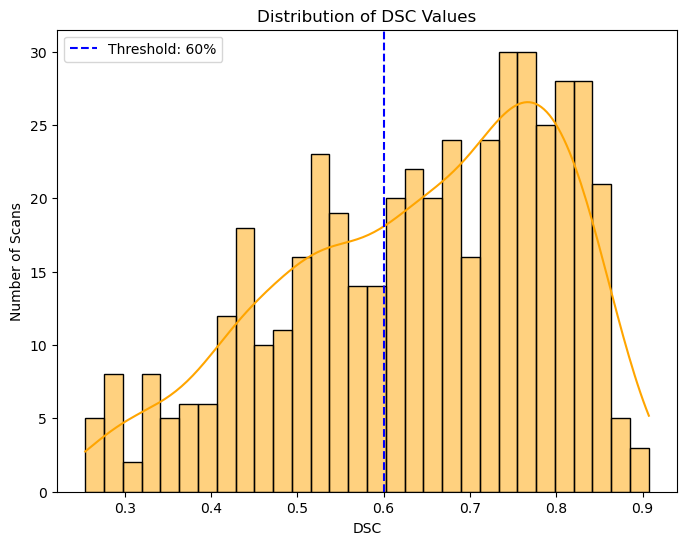

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of DSC values
plt.figure(figsize=(8, 6))
sns.histplot(all_dsc, bins=30, kde=True, color='orange')
plt.axvline(x=0.6, color='blue', linestyle='--', label="Threshold: 60%")
plt.title("Distribution of DSC Values")
plt.xlabel("DSC")
plt.ylabel("Number of Scans")
plt.legend()
plt.show()

In [15]:
print(len(all_dsc))

473


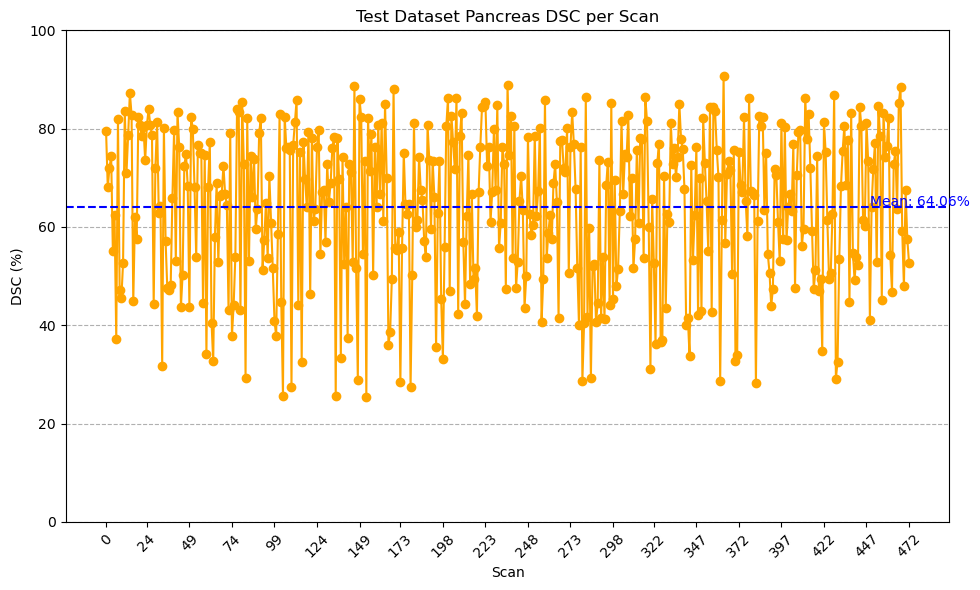

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Datos extraídos manualmente del texto proporcionado
epochs = range(len(all_dsc))
val_pancreas_dsc = all_dsc
# Convertir a porcentaje
val_pancreas_dsc_percent = [dsc * 100 for dsc in val_pancreas_dsc]

# Calcular el valor medio de DSC
mean_dsc = np.mean(val_pancreas_dsc_percent)

# Limitar la cantidad de ticks en el eje X
num_xticks = 20  # Número deseado de ticks en el eje X
xticks_indices = np.linspace(0, len(epochs) - 1, num_xticks, dtype=int)

# Generar la gráfica
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_pancreas_dsc_percent, marker='o', color='orange', linestyle='-', label='Test Dataset Pancreas DSC')

plt.title("Test Dataset Pancreas DSC per Scan")
plt.xlabel("Scan")
plt.ylabel("DSC (%)")

# Configurar los ticks del eje X
plt.xticks(xticks_indices, rotation=45)

# Configurar el límite del eje Y para empezar en 0
plt.ylim(0, 100)  # El eje Y empieza en 0 y termina en 100

# Añadir una línea horizontal para el valor medio del DSC
plt.axhline(mean_dsc, color='blue', linestyle='--', label=f'Mean DSC: {mean_dsc:.2f}%')

# Mostrar el valor numérico de la media en el gráfico
plt.text(len(epochs) * 0.95, mean_dsc + 1, f'Mean: {mean_dsc:.2f}%', color='blue', va='center')

# Eliminar grid innecesaria
plt.grid(True, which='major', axis='y', linestyle='--')  # Solo líneas horizontales ligeras

# Mostrar la gráfica
plt.tight_layout()
plt.show()



In [ ]:
AUCvalues = [
    0.8445789659208688, 0.824713993594772, 0.8151038717328735, 0.8602243603861996, 0.7091202664646046,
    0.7677483991157577, 0.621975336702247, 0.898068716701477, 0.722279373684434, 0.6797454125072794,
    0.6861709169557211, 0.9519993719629902, 0.8188741868187959, 0.9074807339435627, 0.9456846676054481,
    0.8909453166021367, 0.6705172278430308, 0.7631504666025827, 0.8613536473266626, 0.9276575282961351,
    0.9188739492532827, 0.883886655566656, 0.8568788084516796, 0.91426578179468, 0.8987060754165296,
    0.9515532317211394, 0.8902250015197954, 0.6091154483355813, 0.8443283652182137, 0.6588159000239413,
    0.8462714281234219, 0.9041347064287619, 0.8265943677492141, 0.7818807377584375, 0.6322859869927779,
    0.8727980960928883, 0.78081699973496, 0.5683552992998491, 0.6188679172713349, 0.8382395221518244,
    0.7290821645621293, 0.7148615583417799, 0.7609286753082675, 0.9466101745633452, 0.6979115598351034, 0.9277636639942287, 0.9123038344016333, 0.6524544781561076, 0.7233372191476375, 0.6674596696014362,
    0.8364779095500797, 0.9317743917186777, 0.8508768505229437, 0.7021881174149971, 0.9362416558441883,
    0.9060488019382147, 0.8284114607137398, 0.7027309919544652, 0.8845531432063952, 0.8545595852313018,
    0.8715332504275278, 0.655367024105616, 0.8984915112441721, 0.6290339530202329, 0.8597402117585544,
    0.8605761688064699, 0.6432073125395497, 0.6001242359529583, 0.8005575255741575, 0.813286697614235,
    0.7013843184917987, 0.7729834790171036, 0.7933236660154375, 0.8642039781078142, 0.7545442905170071,
    0.773486914644917, 0.6940681348638241, 0.8926580762142446, 0.6432275101939331, 0.7095270835076345,
    0.7213189021341507, 0.9364414324606583, 0.9090394030632175, 0.6684643797416429, 0.9747656578461097,
    0.861218327935363, 0.6124132222255548, 0.865797520436073, 0.8105801153395427, 0.807216365612832, 0.805480447728567, 0.8486813066796955, 0.5689858443192668, 0.7430021461251592,
    0.7901073975137789, 0.9040649728472252, 0.95255179110783, 0.7578244132882797, 0.7104154363442907,
    0.8255046185750543, 0.7232718130567689, 0.7913042496398366, 0.7583791981425304, 0.7391580483501374,
    0.6384209088703575, 0.7407472032179964, 0.5436344359411319, 0.7966168781909273, 0.8838963367411298,
    0.676582434858802, 0.60041996677028, 0.9174219650235526, 0.822205879747278, 0.8263997235352224,
    0.9248690690040867, 0.6655952525780774, 0.8881994167424702, 0.9331674429815938, 0.9258254714716262,
    0.6662422237333875, 0.8953705333948936, 0.6362286867760049, 0.8405325677425691, 0.8684098522923418,
    0.8899549303048085, 0.8537482832607639, 0.6615485973324874, 0.9128390044699382, 0.8481682126115171,
    0.7596526261018293, 0.9178738185367816, 0.9077184154462808, 0.7111864799673058, 0.7842358764009619,
    0.7634847246181505, 0.7883757561934791, 0.8382780911455954, 0.7464088785022724, 0.8196075478394157,
    0.8381164725080239, 0.8795976005799729, 0.9103962778419417, 0.5638779398178447, 0.8489253167173056,
    0.6166336387782294, 0.8406434938253912, 0.6965618825219381, 0.8295612675843671, 0.6483285067941428,
    0.8936062852384267, 0.7908023652791054, 0.740643621513148, 0.9503556180771767, 0.7034412850800149,
    0.5751339479658123, 0.938758892303703, 0.9398906621036962, 0.8735041132441036, 0.8416213298453469,
    0.9008468685152322, 0.8256928185910111, 0.888278224652691, 0.7303930069084376, 0.9342098596057334,
    0.7818050875681286, 0.9368084436987071, 0.7797150435635692, 0.890954683448146, 0.7811240109690631,
    0.9154304786158519, 0.6028109748223264, 0.7850907117491503, 0.7099481897135522, 0.6502135079653187,
    0.692739719197895, 0.9554006420725213, 0.7343767241523368, 0.7841825882460921, 0.7359369975749684,
    0.711652502434574, 0.5071570523500956, 0.876102398309517, 0.8158199610866389, 0.7791650638978813, 0.8443342363695409, 0.652078428998582,
    0.7403379100223618, 0.919393647390575, 0.7982486924411498, 0.7388245745889497, 0.8196105938955656,
    0.8075299286388641, 0.7754318696888916, 0.7907289399939087, 0.767859888458425, 0.8880316974548066,
    0.8832726909407991, 0.4999606136065746, 0.7191289233326028, 0.8498902335875442, 0.84792353520168,
    0.6207022272604972, 0.7574611701432321, 0.8778362388672856, 0.7412779540765586, 0.6858385564278129,
    0.7106986297708174, 0.8725428774806808, 0.9432797731063636, 0.661735515036414, 0.8959515800640009,
    0.8468927689570075, 0.8556086993794415, 0.9064368612175862, 0.664275642599248, 0.5142218678711882,
    0.9230664350081531, 0.8821499754115089, 0.777747226670379, 0.7340852065848646, 0.8375089288322157,
    0.8729067593743618, 0.7969601681582333, 0.8262848116462472, 0.7177726805314545, 0.7483338915319848,
    0.6470189813996261, 0.7828654906363546, 0.8450309549851067, 0.8996132478099917, 0.583357608991654,
    0.9521218713199674, 0.8992341254472902, 0.8158118776558947, 0.845926472339284, 0.7493549323768797,
    0.8155411600331436, 0.853915964264378, 0.7771142562172164, 0.9365522356986214, 0.7557918184732582,
    0.7644191054274412, 0.879499766934804, 0.8945096349412545, 0.6677933427844243, 0.9386552607514305,
    0.8911329317924183, 0.9352823696328716, 0.700847701411015, 0.8808536779170273, 0.7228713864469145,
    0.7297583980033606, 0.7857206961069799, 0.6366794716263852, 0.9241720519379588, 0.7476738078693972,
    0.7135560692863999, 0.7548363398342506, 0.862127994668652, 0.8846268219929325, 0.7708709131868043,
    0.7456609900182535, 0.5777087183641354, 0.9259149803508416, 0.7440224182372727, 0.7771430340065777,
    0.9356032260363896, 0.6427213733296919, 0.740589726291039, 0.9182563505465893, 0.7080478448426571,
    0.734086194454595, 0.7655573711383505, 0.7584054401788339, 0.8628082553669801, 0.7625903954244543, 0.7625903954244543, 0.6496017209453414, 0.8792098721392978, 0.9241412519251229, 0.8468432934963589,
    0.570953724007287, 0.8426162801235727, 0.899986528756234, 0.7224411032230582, 0.9045928437412882,
    0.916101756599447, 0.8706947224845214, 0.7779437421315452, 0.7059580544214469, 0.6313451298566848,
    0.8776426546872382, 0.6669265916863948, 0.6795767657880547, 0.9442960444904868, 0.6504516400119341,
    0.9022877888655628, 0.765400306956473, 0.6951425086206362, 0.6938496392598617, 0.7145344100908729,
    0.8426293774641921, 0.7527583803006721, 0.7185072263695413, 0.6710452438712143, 0.8311559130343127,
    0.8679843528404697, 0.6670236523357362, 0.9656012936792776, 0.6834397512439131, 0.857724281229832,
    0.7663344330424924, 0.7902147985045812, 0.7756587887991674, 0.9441468474123124, 0.8940080670464224,
    0.8700801016465685, 0.5484095049599311, 0.9047619976284127, 0.9093507648693295, 0.7964082920272061,
    0.8662037474857863, 0.7483338915319848, 0.7947155776159188, 0.8972162908000706, 0.795720668134474,
    0.9087782067964799, 0.9131718454120821, 0.7279666961984251, 0.9290027887009048, 0.898854934172914,
    0.8281032512940988, 0.616279172836074, 0.7675086220622483, 0.7337862542035362, 0.7674570819318142,
    0.8559549322941732, 0.9082443211676055, 0.6281834020161717, 0.6172413075651983, 0.8443363530416335,
    0.6739176056992552, 0.7345415432982603, 0.7473074569219683, 0.9549959402099152, 0.9112397403607159,
    0.8837589113828345, 0.9404730609416887, 0.9368596829514044, 0.9248938341528147, 0.84471923863672,
    0.8348908930635098, 0.5498328347593102, 0.789443327107925, 0.6638293364482736, 0.7281485143806951,
    0.6249661317533421, 0.8628306871586054, 0.7103830543485966, 0.764700147398116, 0.8851111123885551,
    0.7263934670438223, 0.7978773471804143, 0.6475019336180975, 0.8772905665682404, 0.8568267097010829,
    0.7622615258976514, 0.7057289253757525, 0.9488432139455173, 0.6723459463188612, 0.9619460865666575,
    0.9185045118386826, 0.921310743016742, 0.8365673953271755, 0.819270334875988, 0.933120348844477,
    0.7230029758091251, 0.8067105022530288, 0.8736856479445017, 0.840680059738365, 0.6945553105000231,
    0.8572131618567427, 0.60830191044303, 0.6390514073572935, 0.8951178558169407, 0.8905095470182443,
    0.7881635965062328, 0.9193954756875868, 0.8154164309371734, 0.5590690347889405, 0.5187585963007656,
    0.7301233291148936, 0.9379002559690235, 0.8005105284690288, 0.7814008178900415, 0.7786183183526354,
    0.7334741648391196, 0.8801115378630586, 0.6341046915834182, 0.8779701190237086, 0.8773277360941462,
    0.7502752750463738, 0.8844031094520612, 0.7973582501054329, 0.6787556603996745, 0.6577110267119726,
    0.7519615998104251, 0.9136988521748897, 0.8404189226744567, 0.7544989485221741, 0.7680930330717681,
    0.9019591453682443, 0.7834744938278639, 0.8944891249697142, 0.7639481396856054, 0.8180768820218891,
    0.5596593453606982, 0.8399420952905181, 0.7553540260381418, 0.8590373597984151, 0.6697875282696835,
    0.794625856703648, 0.9172078349308811, 0.848795346126568, 0.7278330405009026, 0.8218900752576741,
    0.9024970301884939, 0.8913353496854174, 0.9434099712465185, 0.8477464169387503, 0.8624213558580207,
    0.6689555959245598, 0.7164645634869502, 0.8628569473766043, 0.5752975791760551, 0.7197469068105573,
    0.7121290459668754, 0.4999046174952219, 0.5540929557233086, 0.6127191175750449, 0.9231361251959979,
    0.8106127891553674, 0.7947705565573668, 0.7226577521669378, 0.7744987419920679, 0.5063062653368864,
    0.7547653188504071, 0.9496905597270104, 0.6013956664200963, 0.6373479356719731, 0.7283255770760366,
    0.8402324597795581, 0.840019666658848, 0.8680844183335327, 0.7858339938402632, 0.8560504018805617,
    0.6764807590471027, 0.8969879856479716, 0.7650038573432978, 0.6688438373343055, 0.7090719996383889,
    0.695681903467586, 0.9144329250111323, 0.9013158670066435, 0.8098774912170272, 0.7652753495099389,
    0.8941813536077579, 0.8082825531670099, 0.6551815041646223, 0.8018905094210877, 0.8184097903043401
]


monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


actual shape: (300, 300, 321)
actual dtype int64
predicted shape: (300, 300, 321)
predicted dtype int64
actual_cls shape: (300, 300, 321)
actual_cls dtype bool
predicted_cls shape: (300, 300, 321)
predicted_cls dtype bool
actual_cls shape: (300, 300, 321)
actual_cls dtype bool
predicted_cls shape: (300, 300, 321)
predicted_cls dtype bool
[0.99957409 0.68110451]


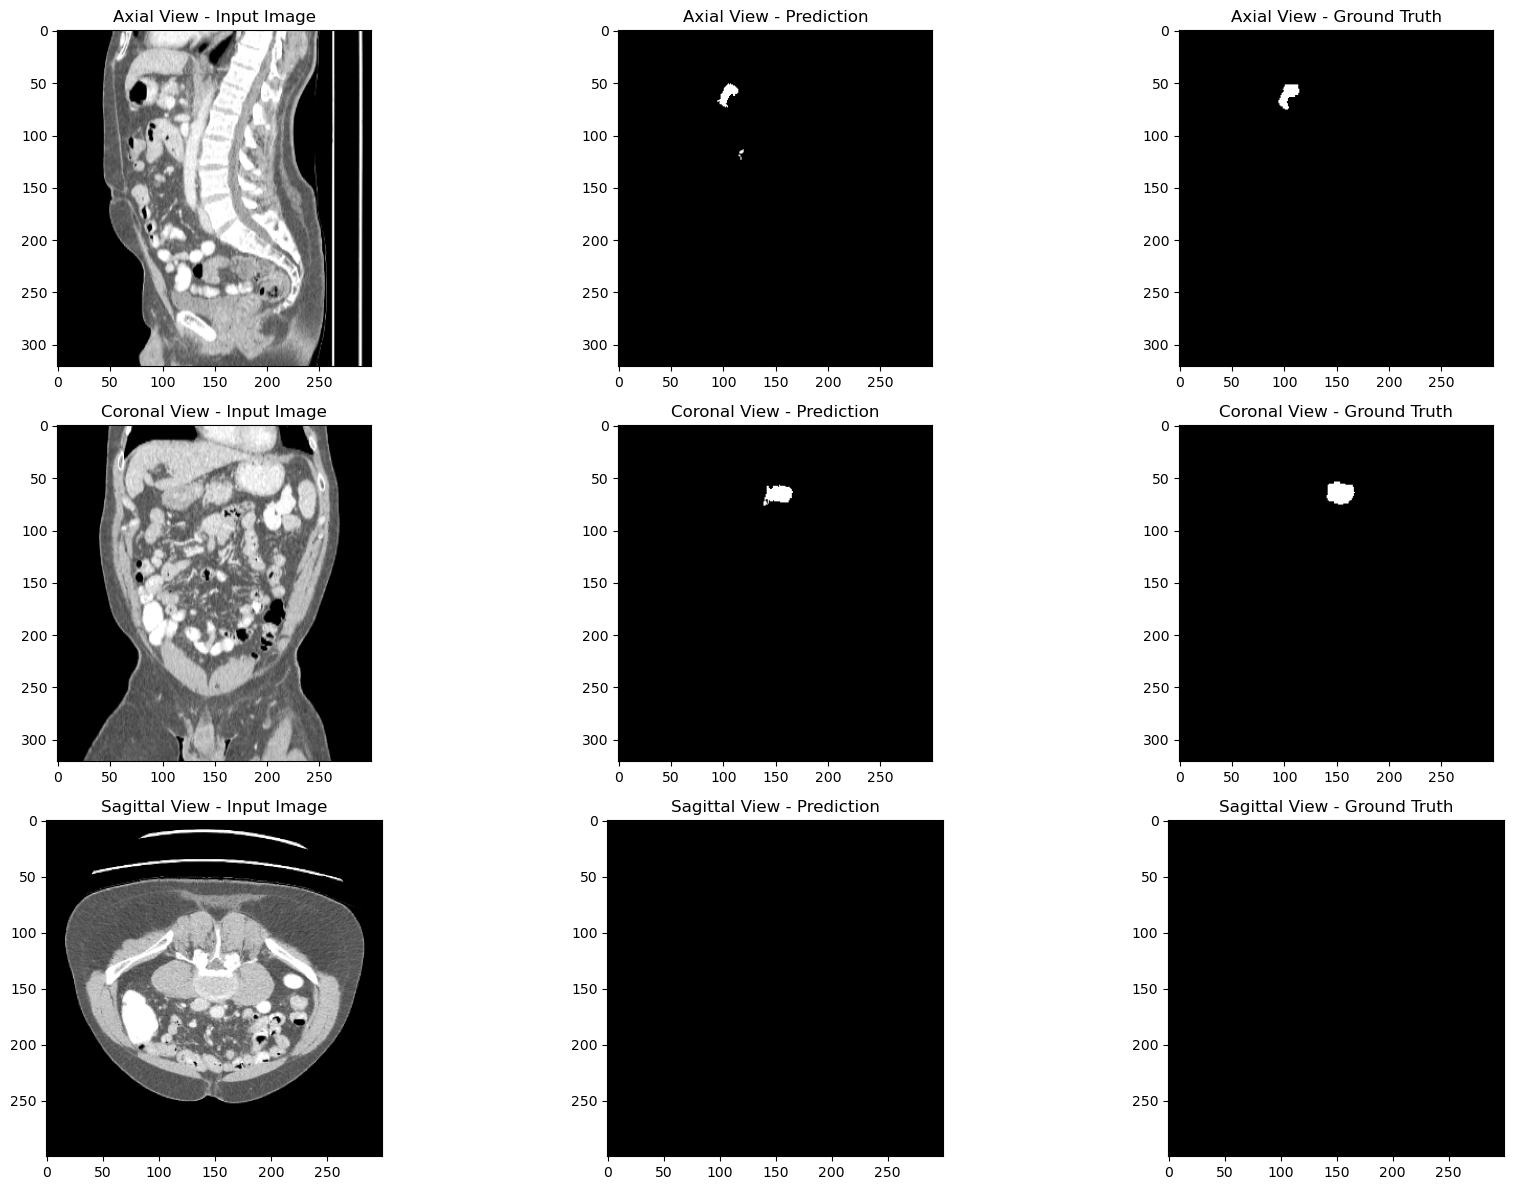

In [6]:
import os
import torch
import pandas as pd
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, 
    ThresholdIntensityd, NormalizeIntensityd, Spacingd, Lambda, AsDiscreted
)
from monai.data import Dataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from utils.loss_factory import get_loss
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Paths and device configuration
data_dir = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data"  
model_path = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/experiments/AMOS_pesos/best_model.pth"  
csv_file = "/data/PANORAMA/cvillaseca/NETWORKS_SEGMENTACIO/BASELINE_SEGMENTACIO/data/infer.csv"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)

# Define test transforms
wl, ww = -40, 400  # For abdominal window
clamp1 = ThresholdIntensityd(keys=('image',), above=False, threshold=wl + (ww / 2), cval=wl + (ww / 2))
clamp2 = ThresholdIntensityd(keys=('image',), above=True, threshold=wl - (ww / 2), cval=wl - (ww / 2))
norm = NormalizeIntensityd(keys=('image',), nonzero=True)
space = Spacingd(keys=('image', 'label'), pixdim=(1.5, 1.5, 1.5), mode=('bilinear', 'nearest'))

def correct_label(l):
    l[l == 1] = 0
    l[l == 2] = 0
    l[l == 3] = 0
    l[l == 4] = 1
    l[l == 5] = 0
    l[l == 6] = 0
    l[l == 7] = 0
    l[l == 8] = 0
    return l

test_org_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    clamp1,
    clamp2,
    norm,
    space,
    Lambda(lambda d: {'image': d['image'], 'label': correct_label(d['label'])}),
    AsDiscreted(keys=('label'), to_onehot=2)
])

# Create a MONAI dataset from the CSV file
class CustomDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __getitem__(self, index):
        data_dict = {
            'image': self.df.iloc[index]['scan'],
            'label': self.df.iloc[index]['label']
        }
        if self.transforms:
            data_dict = self.transforms(data_dict)
        return data_dict

    def __len__(self):
        return len(self.df)
    

def fast_multiclass_dice(actual, predicted, n_classes):
    actual = np.squeeze(np.array(actual))
    predicted = np.squeeze(np.array(predicted))
    print('actual shape:', actual.shape)
    print('actual dtype', actual.dtype)
    print('predicted shape:', predicted.shape)
    print('predicted dtype', predicted.dtype)

    # Initialize an array to store the dice score for each class
    dices = np.zeros(n_classes) 
    for cls in range(n_classes):
        actual_cls = (actual == cls)
        predicted_cls = (predicted == cls)
        actual_cls = np.array(actual_cls).astype(bool)
        predicted_cls = np.array(predicted_cls).astype(bool)
        print('actual_cls shape:', actual_cls.shape)
        print('actual_cls dtype', actual_cls.dtype)
        print('predicted_cls shape:', predicted_cls.shape)
        print('predicted_cls dtype', predicted_cls.dtype)
        
        intersections = np.logical_and(actual_cls, predicted_cls).sum(axis=(0, 1, 2))
        im_sums = actual_cls.sum(axis=(0, 1, 2)) + predicted_cls.sum(axis=(0, 1, 2))
        dices[cls] = 2. * intersections / np.maximum(im_sums, 1e-6)
    return dices


# Define post-processing transforms to get predictions as discrete values
post_transform = Compose([
    AsDiscreted(keys="pred", argmax=True),  # Get class indices from the 5-class predictions
    Lambda(lambda d: {'pred': map_classes_to_binary(d['pred']), 'label': d['label']}),  # Map class 4 to foreground, rest to background
])

def map_classes_to_binary(pred):
    pred = pred.long()

    print(f"Raw prediction shape: {pred.shape}, unique values: {torch.unique(pred)}")

    # Initialize all as background (0)
    binary_pred = torch.zeros_like(pred)

    # Map class 4 to foreground (1)
    binary_pred[pred == 4] = 1

    print(f"Binary prediction shape: {binary_pred.shape}, unique values: {torch.unique(binary_pred)}")

    return binary_pred

# Initialize the dataset and data loader
test_dataset = CustomDataset(df=df, transforms=test_org_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=5, feature_size=12, use_checkpoint=False)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Create an iterator from the test_loader
test_loader_iter = iter(test_loader)

# Skip the first and second values
first = next(test_loader_iter)  # First value
second = next(test_loader_iter)  # Second value

# Get the third value
third = next(test_loader_iter)  # Third value
fourth=  next(test_loader_iter)

fifth=  next(test_loader_iter)

sixth=  next(test_loader_iter)

seventh= next(test_loader_iter)


# Perform inference on a single image
val_data = second  
val_images, val_labels = val_data['image'].to(device), val_data['label']

with torch.no_grad():
    val_outputs = sliding_window_inference(val_images.to(device), (96, 96, 96), 1, model).cpu()
    val_pred = val_outputs.argmax(dim=1).cpu().numpy()

# Map class 4 (pancreas) to 1 and all other classes to 0 (background)
val_pred[val_pred != 4] = 0  
val_pred[val_pred == 4] = 1  

# Convert the ground truth label to class label format from one-hot encoding
val_seg = val_labels.argmax(dim=1).cpu().numpy()

dsc_scores = fast_multiclass_dice(val_seg, val_pred, n_classes=2)
print(dsc_scores)

# Plot the segmentation result and ground truth
def plot_segmentation_views(image, prediction, ground_truth, slice_indices):
    """
    Plots the input image, prediction, and ground truth for axial, coronal, and sagittal views.
    
    Parameters:
    - image: the original CT scan image
    - prediction: the predicted segmentation
    - ground_truth: the ground truth segmentation
    - slice_indices: a dictionary containing the slice indices for each view {'axial': int, 'coronal': int, 'sagittal': int}
    """
    # Get the slice indices for each view
    axial_slice = slice_indices['axial']
    coronal_slice = slice_indices['coronal']
    sagittal_slice = slice_indices['sagittal']

    plt.figure(figsize=(18, 12))

    # Axial view (the one you've already plotted)
    plt.subplot(3, 3, 1)
    plt.imshow(np.rot90(image[0, 0, axial_slice, :, :], k=1), cmap='gray') 
    plt.title('Axial View - Input Image')
    plt.subplot(3, 3, 2)
    plt.imshow(np.rot90(prediction[0, axial_slice, :, :], k=1), cmap='gray') 
    plt.title('Axial View - Prediction')
    plt.subplot(3, 3, 3)
    plt.imshow(np.rot90(ground_truth[0, axial_slice, :, :],k=1), cmap='gray')
    plt.title('Axial View - Ground Truth')

    # Coronal view (slice along axis=1)
    plt.subplot(3, 3, 4)
    plt.imshow(np.rot90(image[0, 0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Input Image')
    plt.subplot(3, 3, 5)
    plt.imshow(np.rot90(prediction[0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Prediction')
    plt.subplot(3, 3, 6)
    plt.imshow(np.rot90(ground_truth[0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Ground Truth')

    # Sagittal view (slice along axis=2)
    plt.subplot(3, 3, 7)
    plt.imshow(np.rot90(image[0, 0, :, :, sagittal_slice],k=1), cmap='gray')
    plt.title('Sagittal View - Input Image')
    plt.subplot(3, 3, 8)
    plt.imshow(np.rot90(prediction[0, :, :, sagittal_slice], k=1), cmap='gray')
    plt.title('Sagittal View - Prediction')
    plt.subplot(3, 3, 9)
    plt.imshow(np.rot90(ground_truth[0, :, :, sagittal_slice],k=1), cmap='gray')
    plt.title('Sagittal View - Ground Truth')

    plt.tight_layout()
    plt.show()


slice_indices = {
    'axial': val_images.shape[2] // 2,     # middle slice for axial view
    'coronal': val_images.shape[3] // 3,   
    'sagittal': val_images.shape[4] // 2  
}

# Call the function to plot the images and segmentations in all three views
plot_segmentation_views(val_images.cpu().numpy(), val_pred, val_seg, slice_indices)


# Select a slice index for visualization (e.g., middle slice)
#slice_idx = val_images.shape[2] // 2

# Call the function to plot the image, prediction, and ground truth
#plot_segmentation_views(val_images.cpu().numpy(), val_pred, val_seg, slice_idx)


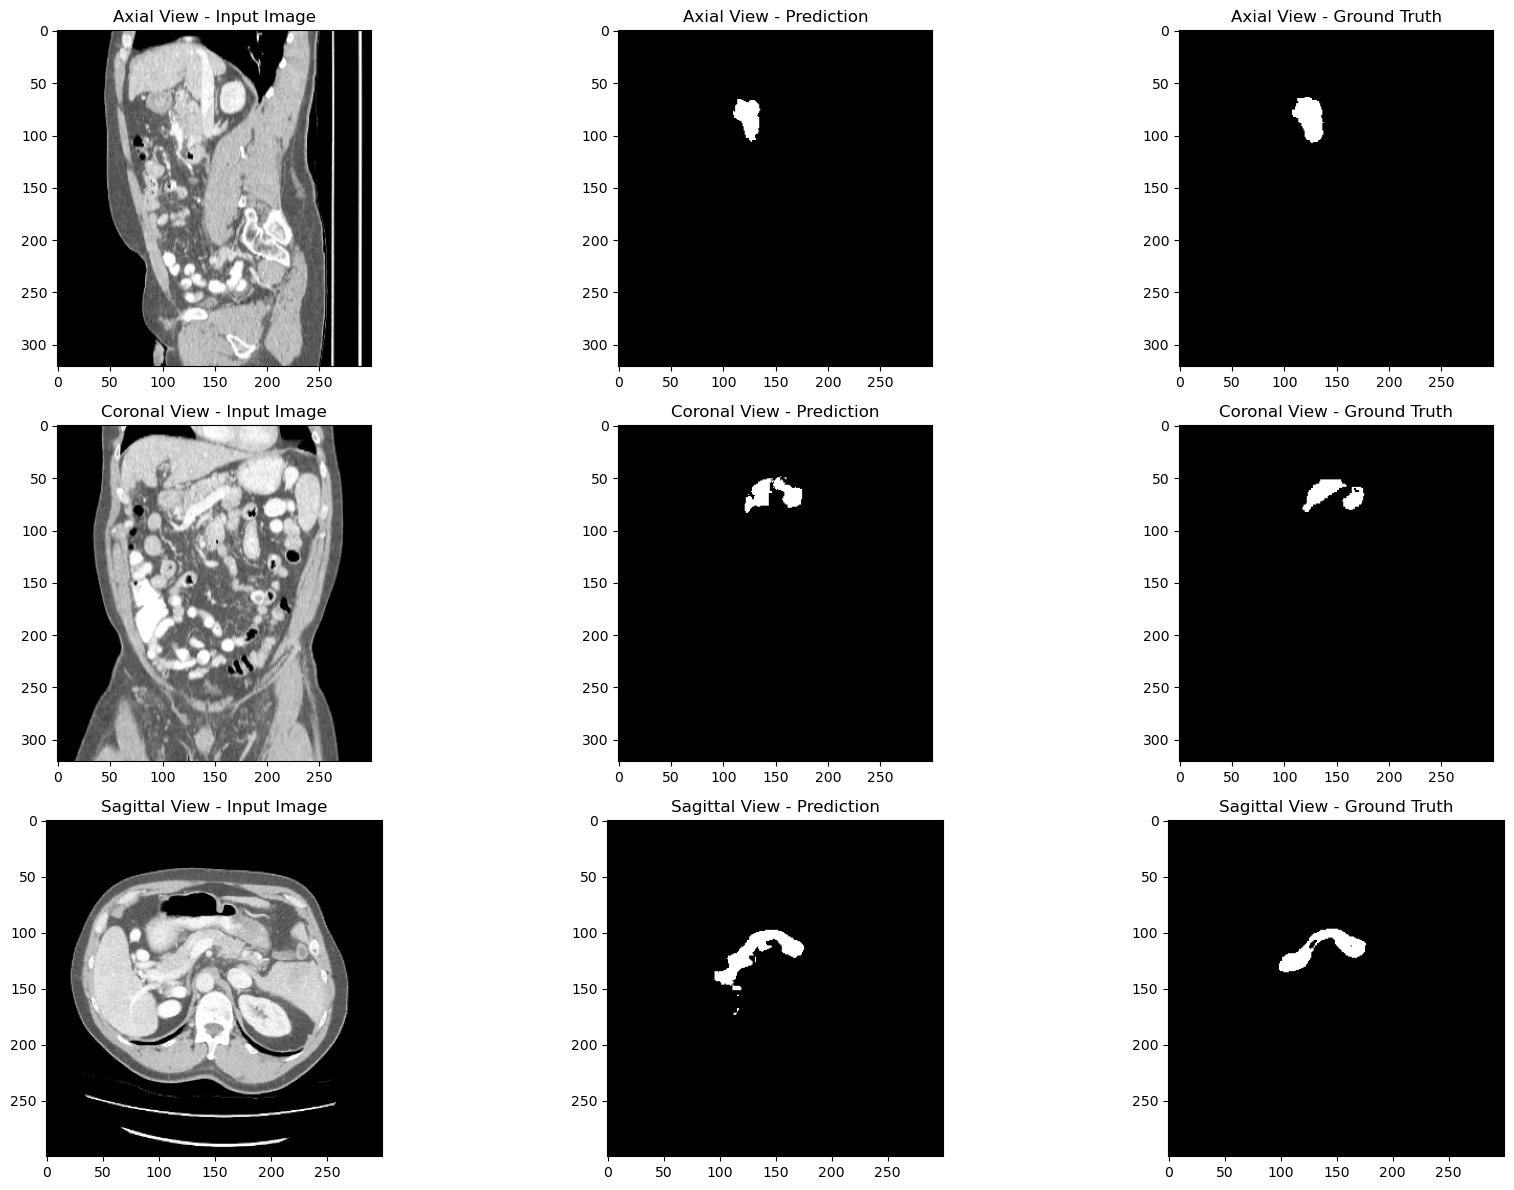

In [7]:
# Plot the segmentation result and ground truth
def plot_segmentation_views(image, prediction, ground_truth, slice_indices):
    """
    Plots the input image, prediction, and ground truth for axial, coronal, and sagittal views.
    
    Parameters:
    - image: the original CT scan image
    - prediction: the predicted segmentation
    - ground_truth: the ground truth segmentation
    - slice_indices: a dictionary containing the slice indices for each view {'axial': int, 'coronal': int, 'sagittal': int}
    """
    # Get the slice indices for each view
    axial_slice = slice_indices['axial']
    coronal_slice = slice_indices['coronal']
    sagittal_slice = slice_indices['sagittal']

    plt.figure(figsize=(18, 12))

    # Axial view (the one you've already plotted)
    plt.subplot(3, 3, 1)
    plt.imshow(np.rot90(image[0, 0, axial_slice, :, :], k=1), cmap='gray') 
    plt.title('Axial View - Input Image')
    plt.subplot(3, 3, 2)
    plt.imshow(np.rot90(prediction[0, axial_slice, :, :], k=1), cmap='gray') 
    plt.title('Axial View - Prediction')
    plt.subplot(3, 3, 3)
    plt.imshow(np.rot90(ground_truth[0, axial_slice, :, :],k=1), cmap='gray')
    plt.title('Axial View - Ground Truth')

    # Coronal view (slice along axis=1)
    plt.subplot(3, 3, 4)
    plt.imshow(np.rot90(image[0, 0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Input Image')
    plt.subplot(3, 3, 5)
    plt.imshow(np.rot90(prediction[0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Prediction')
    plt.subplot(3, 3, 6)
    plt.imshow(np.rot90(ground_truth[0, :, coronal_slice, :],k=1), cmap='gray')
    plt.title('Coronal View - Ground Truth')

    # Sagittal view (slice along axis=2)
    plt.subplot(3, 3, 7)
    plt.imshow(np.rot90(image[0, 0, :, :, sagittal_slice],k=3), cmap='gray')
    plt.title('Sagittal View - Input Image')
    plt.subplot(3, 3, 8)
    plt.imshow(np.rot90(prediction[0, :, :, sagittal_slice], k=3), cmap='gray')
    plt.title('Sagittal View - Prediction')
    plt.subplot(3, 3, 9)
    plt.imshow(np.rot90(ground_truth[0, :, :, sagittal_slice],k=3), cmap='gray')
    plt.title('Sagittal View - Ground Truth')

    plt.tight_layout()
    plt.show()


slice_indices = {
    'axial': 120,     # middle slice for axial view
    'coronal': 109,   
    'sagittal': 257  
}

# Call the function to plot the images and segmentations in all three views
plot_segmentation_views(val_images.cpu().numpy(), val_pred, val_seg, slice_indices)


In [20]:
import matplotlib.pyplot as plt

def get_bounding_box(mask):
    """
    Get the bounding box of the region in the mask where the pancreas is predicted (value 1).
    """
    # Ensure the mask is 3D by removing singleton dimensions (e.g., batch, channel)
    mask_3d = np.squeeze(mask)
    
    # Get the coordinates of non-zero points in the mask (where the pancreas is predicted)
    pancreas_coords = np.argwhere(mask_3d == 1)
    
    # If there are no pancreas pixels, return None
    if pancreas_coords.size == 0:
        return None
    
    # Get the min and max for each dimension (z, y, x)
    min_z, min_y, min_x = pancreas_coords.min(axis=0)
    max_z, max_y, max_x = pancreas_coords.max(axis=0)
    
    # Return the bounding box as (min_z, max_z, min_y, max_y, min_x, max_x)
    return (min_z, max_z, min_y, max_y, min_x, max_x)

In [21]:
def crop_pancreas_from_ct(ct_image, mask):
    """
    Crop the pancreas region from the original CT scan based on the segmentation mask.
    
    Parameters:
    ct_image (numpy array): The original CT scan (3D volume).
    mask (numpy array): The predicted mask for the pancreas.
    
    Returns:
    cropped_ct (numpy array): The cropped CT scan containing only the pancreas region.
    """
    # Get the bounding box for the pancreas
    bounding_box = get_bounding_box(mask)
    
    if bounding_box is None:
        print("No pancreas detected in the prediction.")
        return None
    
    # Unpack the bounding box coordinates
    min_z, max_z, min_y, max_y, min_x, max_x = bounding_box
    
    # Crop the original CT scan using the bounding box
    cropped_ct = ct_image[min_z:max_z+1, min_y:max_y+1, min_x:max_x+1]
    
    # Return the cropped pancreas region
    return cropped_ct

In [38]:
def visualize_sagittal_slice(cropped_ct):
    """
    Visualize the middle sagittal slice of the cropped pancreas region.
    
    Parameters:
    cropped_ct (numpy array): The cropped CT scan containing the pancreas region.
    """
    if cropped_ct is not None:
        # Get the middle slice along the x-axis (sagittal view)
        middle_slice_x = 180
        
        # Display the middle sagittal slice
        plt.imshow(np.rot90(cropped_ct[:, :, middle_slice_x], k=3), cmap="gray")
        plt.title("Cropped Pancreas Region (Sagittal Slice)")
        plt.show()
    else:
        print("No region to display.")

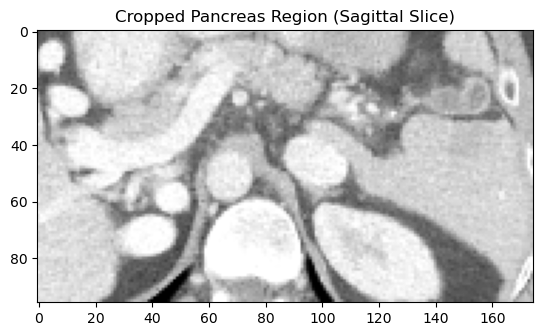

In [39]:
# Assuming val_images is your original CT scan and val_pred is your pancreas prediction
val_images_np = val_images.cpu().numpy()[0, 0]  # Convert torch tensor to numpy (original CT)
val_pred_np = val_pred  # Prediction mask (already in numpy)

# Crop the pancreas from the original CT based on the prediction
cropped_ct = crop_pancreas_from_ct(val_images_np, val_pred_np)

# Visualize the middle slice of the cropped pancreas region
visualize_sagittal_slice(cropped_ct)

In [62]:
import scipy.ndimage as ndimage

def extract_largest_component(mask):
    """
    Extract the largest connected component from the binary mask.
    
    Parameters:
    mask (numpy array): Binary mask of the predicted pancreas region.
    
    Returns:
    numpy array: Mask with only the largest connected component.
    """
    labeled_mask, num_labels = ndimage.label(mask)
    sizes = ndimage.sum(mask, labeled_mask, range(num_labels + 1))
    largest_label = sizes.argmax()
    largest_component = labeled_mask == largest_label
    return largest_component.astype(int)

def find_largest_cross_section(mask):
    """
    Find the slice with the largest cross-sectional area in the sagittal plane.
    
    Parameters:
    mask (numpy array): Binary mask for the pancreas.
    
    Returns:
    int: Index of the slice with the largest cross-sectional area.
    """
    # Calculate the area (sum of pixels) for each sagittal slice (along the x-axis)
    areas = mask.sum(axis=(0, 1))  # Summing over z and y axes to get the sagittal plane
    largest_slice_idx = areas.argmax()
    return largest_slice_idx


def crop_pancreas_from_ct(ct_image, mask):
    """
    Crop the pancreas region from the original CT scan based on the segmentation mask.
    
    Parameters:
    ct_image (numpy array): Original CT scan.
    mask (numpy array): Binary segmentation mask where the pancreas is labeled as 1.
    
    Returns:
    cropped_ct (numpy array): The cropped CT scan containing only the pancreas region.
    cropped_mask (numpy array): The cropped binary mask containing only the pancreas region.
    """
    # Get the bounding box for the pancreas
    bounding_box = get_bounding_box(mask)

    if bounding_box is None:
        print("No pancreas detected in the prediction.")
        return None, None
    
    min_z, max_z, min_y, max_y, min_x, max_x = bounding_box

    # Crop the CT image and the mask using the bounding box
    cropped_ct = ct_image[min_z:max_z, min_y:max_y, min_x:max_x]
    cropped_mask = mask[min_z:max_z, min_y:max_y, min_x:max_x]

    return cropped_ct, cropped_mask  # Return both the cropped CT and cropped mask


In [63]:
def visualize_largest_sagittal_slice(cropped_ct, cropped_mask):
    """
    Visualize the largest cross-sectional sagittal slice of the cropped CT scan.

    Parameters:
    cropped_ct (numpy array): The cropped CT scan.
    cropped_mask (numpy array): The binary segmentation mask for the cropped region.
    """
    # Find the largest cross-section in the sagittal view (x-axis) within the cropped mask
    largest_slice_x_relative = find_largest_cross_section(cropped_mask)

    # Ensure the index is within bounds of the cropped CT scan
    if largest_slice_x_relative < 0 or largest_slice_x_relative >= cropped_ct.shape[2]:
        raise IndexError(f"Adjusted index {largest_slice_x_relative} is out of bounds for axis 2 with size {cropped_ct.shape[2]}")

    # Visualize the largest sagittal slice
    plt.imshow(cropped_ct[:, :, largest_slice_x_relative], cmap="gray")
    plt.title("Cropped Pancreas Region (Largest Sagittal Slice)")
    plt.show()

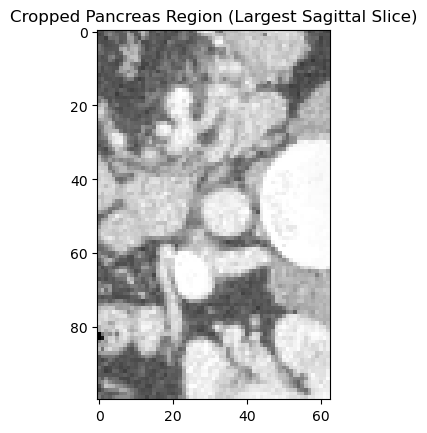

In [64]:
# Use the updated functions
largest_component_mask = extract_largest_component(val_pred)
cropped_ct, cropped_mask = crop_pancreas_from_ct(val_images_np, largest_component_mask)

# Visualize the largest cross-sectional sagittal slice
visualize_largest_sagittal_slice(cropped_ct, cropped_mask)